# Trabalho Final de Aprendizado de Máquina

Este trabalho tem como um de seus objetivos construir um modelo de aprendizado de máquina para praticar e demonstrar os conceitos aprendidos em sala de aula.

Alguns dos conceitos mais interessantes aprendidos em sala de aula se encontram na área de Processamento de Linguagem Natural, normalmente referida como NLP (de Natural Language Processing). Os modelos de aprendizado de máquina encontrados na área de NLP são capazes de classificar e fazer regressões sobre dados bem abstratos, que são compostos por palavras de linguagem natural. Isso torna o processo de aprendizado e representação do dado muito mais complexo. Por isso, este trabalho se destina a contruir um modelo de aprendizado de máquina capaz de reconhecer notícias falsas. Para este fim, foi utilizada uma base de dados de notícias na língua inglesa, que pode ser encontrada em [aqui](https://raw.githubusercontent.com/lgcaetano/TP3ML/master/news.csv), classificadas como verdadeiras ou falsas. A maioria das notícias utilizadas são realcionadas à política americana. No decorrer do trabalho foram realizados experimentos com diversos modelos para representação das notícias e classificação das representações para aperfeiçoar o modelo final, alguns destes experimentos também estão documentados no trabalho para melhor exntendimento dos conceitos e algoritmos utilizados.

## Construindo o modelo

Para que possamos utilizar os algoritmos mais conhecidos para classificar as notícias, precismos de alguma forma representar seu conteúdo de forma matemática. A representação dos dados na verdade, é a parte mais complexa do problema, já que estamos tratando de um dado muito abstrato e que possui uma classificação abstrata, como as notícias podem ser classificadas como falsas ou verdadeiras. 

Uma das formas de representar texto matematicamente é através de um vetorizador TF-IDF, que recebe uma coleção de documentos (as notícias, neste caso) e os converte em um vetor ou matriz que pode ser utilizada como a entrada de um modelo de aprendizado qualquer. TF-IDF se refere a TF (term frequency) frequência de certo termo em certo documento, e IDF (inverted document frequency) que indica o quão incomum é o termo em todos os documentos. A multiplicação dessas duas razões dá o valor de certo termo na matriz que representa certo documento, ou seja termos que aparecem mais em certo documento do que em outros acabm tendo um alto valor TF-IDF associado.

Também é possível utilizar vetorizadores mais simples como os algoritmos `CountVectorizer` e `HashingVectorizer`, que assim como `TfidfVectorizer`, são disponibilizados pela biblioteca `scikit-learn`. Estes algoritmos não consideram a infrequência de certo termo nos demais documentos, ao contrário dos vetorizadores TF-IDF. As três possibilidades de vetorizadores serão utilizadas e a performance do mesmo modelo com cada uma será comaprada

Além disso, foram testados alguns modelos disponibilizados pelo `scikit-learn`, como `RandomForestClassifier` e `GradientBoostingClassifier` que são algoritmos considerados poderosos e resistentes a *overfitting*, e dentre os dois, o Random Forest apresentou resultados melhores, independentemente do vetorizador utilizado. 

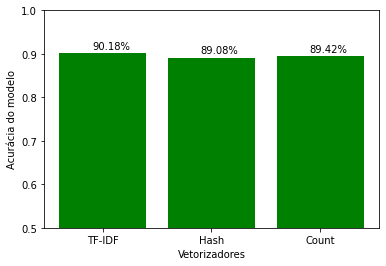

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score


dataframe = pd.read_csv("https://raw.githubusercontent.com/lgcaetano/TP3ML/master/news.csv")

raw_x_data = dataframe['text'] + dataframe['title']
y_data = dataframe['label']

tfidf_vectorizer = TfidfVectorizer(max_df=0.3)
hash_vectorizer = HashingVectorizer()
count_vectorizer = CountVectorizer()

tfidf_vectorizer.fit(dataframe['text'])
hash_vectorizer.fit(dataframe['text'])
count_vectorizer.fit(dataframe['text'])
tfidf_vectorizer.fit(dataframe['title'])
hash_vectorizer.fit(dataframe['title'])
count_vectorizer.fit(dataframe['title'])

def generate_transformer(vectorizer):
    return FeatureUnion([('title_tfidf', Pipeline([('extract_field', FunctionTransformer(lambda x: x['title'], validate=False)), ('tfidf', vectorizer)])),
                         ('text_tfidf', Pipeline([('extract_field', FunctionTransformer(lambda x: x['text'], validate=False)), ('tfidf', vectorizer)]))])

tfidf_transformer = generate_transformer(tfidf_vectorizer)
count_transformer = generate_transformer(count_vectorizer)
hash_transformer = generate_transformer(count_vectorizer)

tfidf_x = tfidf_transformer.transform(dataframe)
count_x = count_transformer.transform(dataframe)
hash_x = hash_transformer.transform(dataframe)

rf_clf = RandomForestClassifier(n_estimators=100)
gb_clf = GradientBoostingClassifier(n_estimators=50)

def cross_validate(model, x):
    return cross_val_score(model, x, y_data, cv=5).mean()

def print_name_score(name, score):
    print(f'{name}: {score}')

def validate_print(model, name, x):
    print_name_score(name, cross_validate(model, x))

def bar_plot_results(xlabel, ylabel, bar_labels, scores, color="green"):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.bar(bar_labels, scores, color=color)
    plt.gca().set_ylim([0.5, 1])
    for i, s in enumerate(scores):
        plt.text(i - 0.1, s + 0.01, f"{round(s * 100, 2)}%")
    plt.show()

vectorizer_labels = ["TF-IDF", "Hash", "Count"]
rf_tfidf_score = cross_validate(rf_clf, tfidf_x)
rf_hash_score = cross_validate(rf_clf, hash_x)
rf_count_score = cross_validate(rf_clf, count_x)
vectorizer_scores = [rf_tfidf_score, rf_hash_score, rf_count_score]

bar_plot_results("Vetorizadores", "Acurácia do modelo", vectorizer_labels, vectorizer_scores)

### Analisando o resultado

Como se pode ver na figura, o algoritmo apresenta boa acurácia independentemente do vetorizador utilizado, o que indica que a vantagem teórica do vetorizador TF-IDF de considerar a frequência relativa dos termos não trouxe grandes benefícios para a representação.

### Tentando aprimorar a representação

Apesar de apresentarem formas interessantes de representar texto, os vetorizadores mencionados não são capazes de reconhecer qualquer tipo de relação entre as palavras de um texto, representam apenas a frequência delas, seja ela relativa ou não. Isso acaba limitando muito o algoritmo, ainda mais considerando que estamos lidando com dados de linguagem natural, já que a informação muitas vezes é somente encontrada na relação entre as palavras.

Por causa disso, foi buscada uma forma diferente de representar as notícias da base de dados. Um dos algoritmos mais famosos para representação de **palavras** é o `word2vec`. Este algoritmo encontra representações para as palavras através de uma rede neural que tem como pesos as representações vetoriais das palavras. O modelo recebe um contexto (uma frase incompleta) como parâmetro e tenta predizer qual será a próxima palavra no contexto. Ao fazer as correções no treino, o modelo ajusta as representações de tal forma que modelos semanticamente próximos também possuam representações matematicamente próximas. Por exemplo, as palavras cão e gato provavelmente possuem representações parecidas, já que consistem em duas espécies de animais de estimação, são conceitos que possuem similaridade e que aparecem em contextos semelhantes no universo da linguagem natural.

Contudo, como não estamos lidando com palavras, o `word2vec` não é suficiente. Para conseguirmos uma representação para os documentos, precisamos usar o `doc2vec` que funciona de forma extremamente similar ao `word2vec` e foi criado pelas mesmas pessoas. Para representar o documento é adicionado outro vetor de representação ao algoritmo `word2vec` que representa o próprio documento. Este vetor é ajustado no treinamento assim como os vetores de palavras e ao final do treinamento, se tem uma representação para o documento.

Após utilizarmos a representação do `doc2vec`, compararemos a performance do algoritmo Random Forest com a sua representação com a performance com a representação dada pelo vetorizador TF-IDF.

[nltk_data] Downloading package punkt to /home/lgcaetano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████| 6335/6335 [00:00<00:00, 1469386.49it/s]


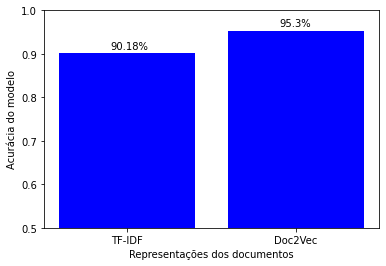

In [2]:
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


cores = multiprocessing.cpu_count()

def get_tagged_x_data(df):
    return df.apply(lambda d: TaggedDocument(words=tokenize_text(d['text']), tags=[d.label]), axis=1)

tagged_x_data = get_tagged_x_data(dataframe)

d2v_model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, workers=cores)
d2v_model.build_vocab([x for x in tqdm(tagged_x_data.values)])

d2v_model.train(utils.shuffle([x for x in tqdm(tagged_x_data.values)]), total_examples=len(tagged_x_data.values), epochs=10)

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    # targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    regressors = [model.infer_vector(doc.words) for doc in sents]
    return regressors

doc2vec_x = vec_for_learning(d2v_model, tagged_x_data)

# validate_print(rf_clf, "DOC2VEC RF: ", doc2vec_x)

rf_d2v_score = cross_validate(rf_clf, doc2vec_x)

doc2vec_labels = ["TF-IDF", "Doc2Vec"]
doc2vec_scores = [rf_tfidf_score, rf_d2v_score]

bar_plot_results("Representações dos documentos", "Acurácia do modelo", doc2vec_labels, doc2vec_scores, color="blue")



### Analisando resultado do experimento

Como pode ser visto no gráfico, o uso da representação dada pelo `doc2vec` trás benefícios significativos ao nosso modelo, reduzindo a taxa de erro consideravelmente, enquanto a taxa de erro com o TF-IDF girava em torno de 10%, com o Doc2Vec, essa taxa tende a ficar próxima de 5%. Isso mostra a superioridade do Doc2Vec, que consegue gerar representações mais úteis dos documentos.

Vale ressaltar que os resultados usando `doc2vec` foram ainda melhores utilizando outros hiperparâmetros na sua configuração, mas o uso destas se tornou inviável devido ao gasto excessivo de tempo para execução.

### Usando XGBoost

Ainda que os resultados apresentados combinando a representação do `doc2vec` com o algoritmo Random Forest tenham sido bons, com acurácia girando em torno dos 95%, o ideal seria aumentar ainda mais esta estatística. Afinal, a proposta deste trabalho é criar um modelo que seja capaz de classificar notícias como falsas ou verdadeiras, definitivamente estamos lidando com um assunto sensível, o que torna a acurácia do nosso algoritmo algo mais crítico. Se este modelo fosse utilizado em uma situação real e cometesse um erro, as consequências poderiam ser drásticas. 

É com esse propósito que foi introduzido o XGBoost, de *Extreme Gradient Boosting*, um algoritmo de *boosting* que usa de técnicas inteligentes de regularização e *feature selection* que fazem com que ele geralmente tenha performance melhor que a de outros algoritmos. O XGBoost ganhou notoriedade recentemente por ter sido utilizado por diversos projetos vencedores de competições de aprendizado de máquina.

Para verificar se o XGBoost de fato nos dá uma vantagem em relação ao Random Forest

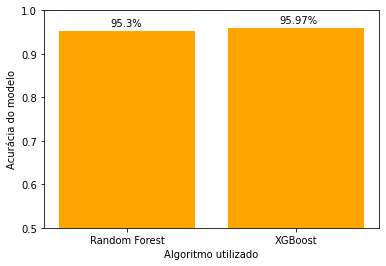

In [3]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

label_encoder = LabelEncoder()

xgb_y = label_encoder.fit_transform(y_data)

xgb_clf = xgb.XGBClassifier()

xgb_score = cross_val_score(xgb_clf, doc2vec_x, xgb_y, cv=5).mean()

xgb_labels = ["Random Forest", "XGBoost"]
xgb_scores = [rf_d2v_score, xgb_score]

bar_plot_results("Algoritmo utilizado", "Acurácia do modelo", xgb_labels, xgb_scores, color="orange")

# xgb_clf.fit(doc2vec_x, xgb_y)


### Analisando resultados

Como pode ser observado no gráfico acima, a utilização do XGBoost de fato trás uma melhoria na acurácia do algoritmo, ainda que não pareça muito expressiva em termos absolutos. Considerando que a acurácia do modelo usando o XGBoost gira em torno de 96% contra 95% usando Random Forest, temos uma redução que gira em torno de 20% na taxa de erro, uma melhora substancial.

## Demonstração do modelo final

Como os experimentos determinaram, a melhor combinação encontrada de representação dos dados e algritmo de classificação foi: `doc2vec` + `xgboost`, o que não é surpreendente considerando que as duas bibliotecas são muito utilizadas. Esta combinação será utilizada no nosso modelo final, para ser utilizada com novos exemplos.

In [16]:
# class FinalModel:
#     def __init__(self):
#         self.model = xgb.XGBClassifier
#         self.doc2vec = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
#     def fit(X, Y, text_selector=lambda d: d['text']):
#         self.doc2vec.build_vocab([x for x in tqdm(X.values)])
#         self.doc2vec.train(utils.shuffle([x for x in tqdm(X.values)]), total_examples=len(tagged_x_data.values), epochs=10)
from sklearn.model_selection import train_test_split
from random import randint

text_vec_pairs = []

for i in range(len(doc2vec_x)):
    text_vec_pairs.append((dataframe['title'][i], dataframe['text'][i], doc2vec_x[i]))
    

X_train, X_test, Y_train, Y_test = train_test_split(text_vec_pairs, xgb_y, test_size=0.1, random_state=97)


xgb_clf.fit([x[2] for x in X_train], Y_train)
final_model = xgb_clf

def predict_random_test_sample():
    random_index = randint(0, len(X_test) - 1)
    sample = X_test[random_index]
    ans = label_encoder.inverse_transform(final_model.predict([sample[2]]))[0]
    correct_ans = label_encoder.inverse_transform([Y_test[random_index]])[0]
    print(f'Original Title: {sample[0]}\nOriginal Text: {sample[1]}\nModel prediction: {ans}\nCorrect answer: {correct_ans}')
    return ans == correct_ans


    


### Demonstração

Para executar uma predição do modelo sobre um exemplo de teste aleatório, basta executar a célula a seguir. Se a célula anterior for executada, o dataset será separado novamente entre dados de treino e de teste e o modelo será retreinado, assim, pode-se obter outros exemplos para serem utilizados como teste na célula a seguir.

In [46]:
print(f'MODELO {"ACERTOU" if predict_random_test_sample() else "ERROU"}')

Original Title: NO jail time for Muslim migrant who DUMPED BABY in road and left it for dead
Original Text: This is now becoming the norm. Just yesterday, I reported on a Muslim migrant who anally raped a 10-year-old boy and had his conviction overturned because “he didn’t know the boy didn’t want to be raped.” 
Islamic supremacism in the West. 
“No jail time for asylum seeker who dumped baby in road,” The Local, 19 Oct 2016: 
A man who was furious at being thrown out of an asylum centre grabbed his own child and dumped her in the middle of a busy road – and has been given a nine-month suspended sentence. 
The 27-year-old had been living in an asylum centre in Vienna’s Floridsdorf district and had already been given several warnings for being drunk and violent. 
So when he turned up again intoxicated with a beer in his hand and was told to leave, he flew into a furious rage. 
Spotting his baby daughter in a pram nearby, he grabbed her and ran into the busy road, and put her in the midd